In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import random
import cvxopt as opt
from cvxopt import blas, solvers
import seaborn as sns

import keras.backend as K
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Flatten, Dense

In [2]:
# Plotting aesthetics
# From https://pat-laub.github.io/DeepLearningForActuaries/Lecture-7-Natural-Language-Processing/natural-language-processing.html#/an-aside-on-colours
# This is the default colour scheme.
colours = [
    "tab:blue", "tab:orange", "tab:green", "tab:red",
    "tab:purple", "tab:brown", "tab:pink","tab:gray",
    "tab:olive", "tab:cyan",
]
colours.remove("tab:orange")
# Set the default color scheme so that this orange is skipped.
import cycler
plt.rcParams["axes.prop_cycle"] = cycler.cycler(color=colours)

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

Importing Data (for reference)

In [3]:
def get_prices(tickers):
  '''
  Extracts the daily closing prices of chosen tickers from yfinance

  inputs: tickers - list of tickers
  returns: DataFrame of historical daily closing prices of chosen tickers
  '''
  close_prices = pd.DataFrame()
  for ticker in tickers:
    obj = yf.Ticker(ticker)
    hist = obj.history(start = "2012-06-01",
                          end = "2022-06-01",
                          auto_adjust = True,
                          interval = "1d").dropna()
    close_prices[ticker] = hist.Close

  return close_prices


MV Helper Function

In [4]:
def MV_weights(returns, long_only = True):
  # Adapted from https://github.com/zhangyi-hu/pymcef/blob/master/examples/1.%20When%20mean%20variance%20models%20fail.ipynb
  '''
  Computes the portfolio weights which result in the greatest sharpe ratio

  inputs: returns - numpy array of returns, with timestep rows and stocks columns
  returns: 
    x_sharpe - optimal portfolio weights
    sd_sharpe - standard deviation of optimal portfolio
    mean_sharpe - expected return of optimal portfolio
    np.array(sd_ef) - numpy array of standard deviations on frontier
    Rs_ef - numpy array of expected returns on frontier
  '''

  # returns should have shape (n_days, n_stocks)
  expected_returns = returns.mean(axis = 0)
  cov_matrix = np.cov(returns.T)

  num_points = 100
  n_assets = len(expected_returns)

  # Defining matrices for optimisation
  Sigma = opt.matrix(cov_matrix)
  mu_vec = opt.matrix(expected_returns)
  zero_vec = opt.matrix(0.0, (n_assets, 1))
  one_vec = opt.matrix(1.0, (n_assets, 1))
  I = opt.matrix(np.eye(n_assets))
  A = opt.matrix([one_vec.T, mu_vec.T])

  sharpe_max = -1_000_000

  # suppress optim output
  solvers.options['show_progress'] = False

  Rs_ef, sd_ef = np.linspace(min(mu_vec), max(mu_vec), num_points), []
  for R in Rs_ef:
    b = opt.matrix([1.0, R])

    if long_only:
      sol = solvers.qp(P = Sigma, q = zero_vec, G = -I, h = zero_vec, A = A, b = b)
    else:
      sol = solvers.qp(P = Sigma, q = zero_vec, A = A, b = b)
    
    sd = np.sqrt(2 * sol['primal objective'])
    sd_ef.append(sd)

    sharpe = R/sd
    if sharpe > sharpe_max:
      sharpe_max = sharpe
      x_sharpe = np.array(sol["x"]).flatten()
      sd_sharpe = sd
      mean_sharpe = R

  return x_sharpe, sd_sharpe, mean_sharpe, np.array(sd_ef), Rs_ef

In [5]:
def sharpe_ratio(portfolio_returns):
  '''
  Computes sharpe ratio of portfolio

  inputs: portfolio_returns - array of portfolio returns
  returns: portfolio_sharpe - sharpe ratio
  '''
  portfolio_sharpe = portfolio_returns.mean() / portfolio_returns.std()
  return portfolio_sharpe

Importing and cleaning data

In [6]:
# prices.csv contains historical prices which have been obtained via get_prices
prices = pd.read_csv("prices.csv", index_col = 0)
returns = prices.pct_change().iloc[1:]

# Remove first index of prices
prices = prices.iloc[1:]
assert prices.shape[0] == returns.shape[0]

tickers = ["WOW.AX", "QBE.AX", "COH.AX", "ORG.AX", "TWE.AX",
           "BHP.AX", "CBA.AX", "TLS.AX", "GMG.AX", "ALL.AX"]
# First 3 tickers for 3 ticker case
# First 5 tickers for 5 ticker case
# All 10 tickers for 10 ticker case

MV Results

WOW.AX    0.0321
QBE.AX    0.0294
COH.AX    0.0740
ORG.AX    0.0146
TWE.AX    0.0731
BHP.AX    0.0535
CBA.AX    0.0578
TLS.AX    0.0262
GMG.AX    0.0956
ALL.AX    0.1242
dtype: float64


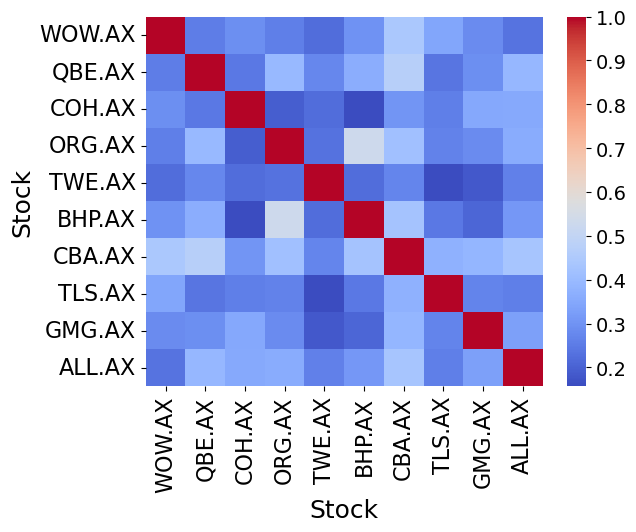

In [7]:
# Correlation matrix plot
# Vector of expected returns and covariance matrix
expected_returns = returns.mean(axis = 0)
cov_matrix = np.cov(returns.T)
print(round(expected_returns * 100, 4))

ax = sns.heatmap(returns.corr(), cmap='coolwarm')
plt.xlabel('Stock', fontsize = 18)
plt.ylabel('Stock', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
# colorbar label size
cax = ax.figure.axes[-1]
cax.tick_params(labelsize = 14)

plt.show()



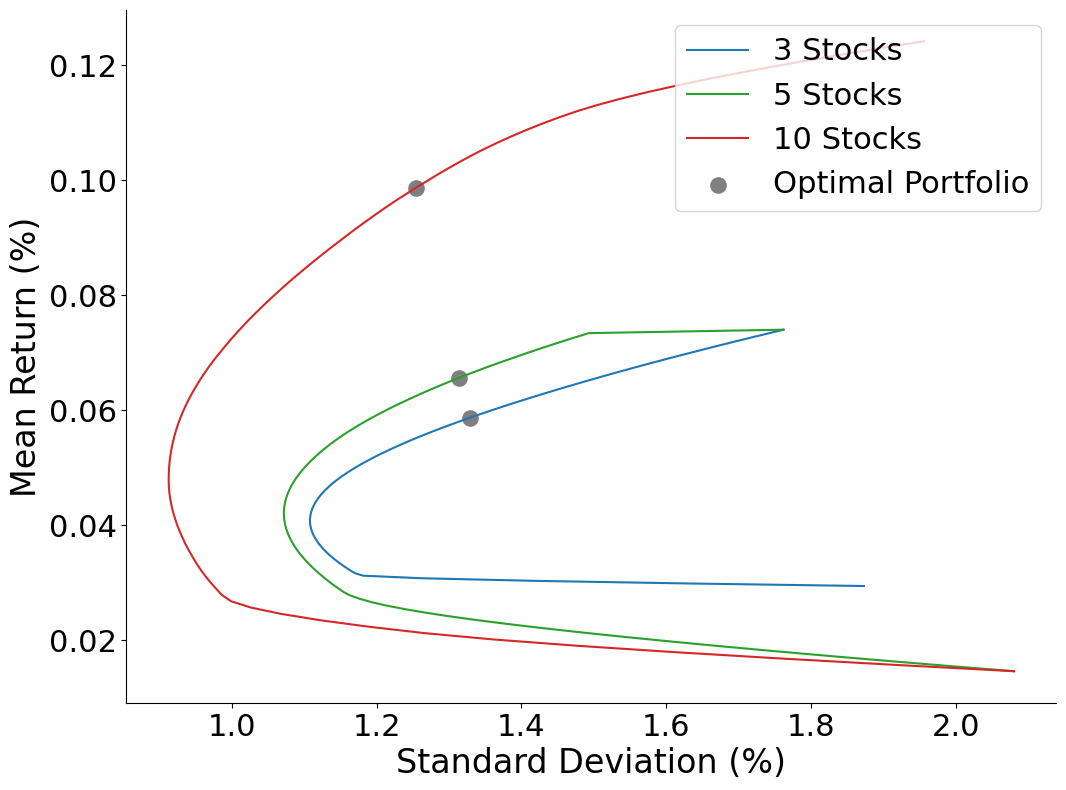

In [8]:
# Stacked frontier graph
portfolio_allocations = {}
portfolio_returns = {}
portfolio_sharpe = {}

sd_sharpes = []
mu_sharpes = []

plt.figure(figsize = (12, 9))
plt.xlabel('Standard Deviation (%)', fontsize = 24)
plt.ylabel('Mean Return (%)', fontsize = 24)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)


for n in [3, 5, 10]:
    allocations, sd_optimal, mu_optimal, sd_x, mu_x = MV_weights(np.array(returns.iloc[:, :n]))

    # Stacking Minimum variance frontiers
    plt.plot(100 * sd_x, 100 * mu_x, label = f"{n} Stocks")

    port_returns = np.multiply(returns.iloc[:, :n].values, allocations).sum(axis = 1)
    port_sharpe = sharpe_ratio(port_returns)
    # Storing results
    portfolio_allocations[f"MV{n}"] = allocations
    portfolio_returns[f"MV{n}"] = port_returns
    portfolio_sharpe[f"MV{n}"] = port_sharpe

    sd_sharpes.append(sd_optimal)
    mu_sharpes.append(mu_optimal)

sd_sharpes = np.array(sd_sharpes)
mu_sharpes = np.array(mu_sharpes)
plt.scatter(100 * sd_sharpes, 100 * mu_sharpes, label = "Optimal Portfolio", color = "tab:grey", s = 120)
plt.legend(fontsize = 22)
plt.show()

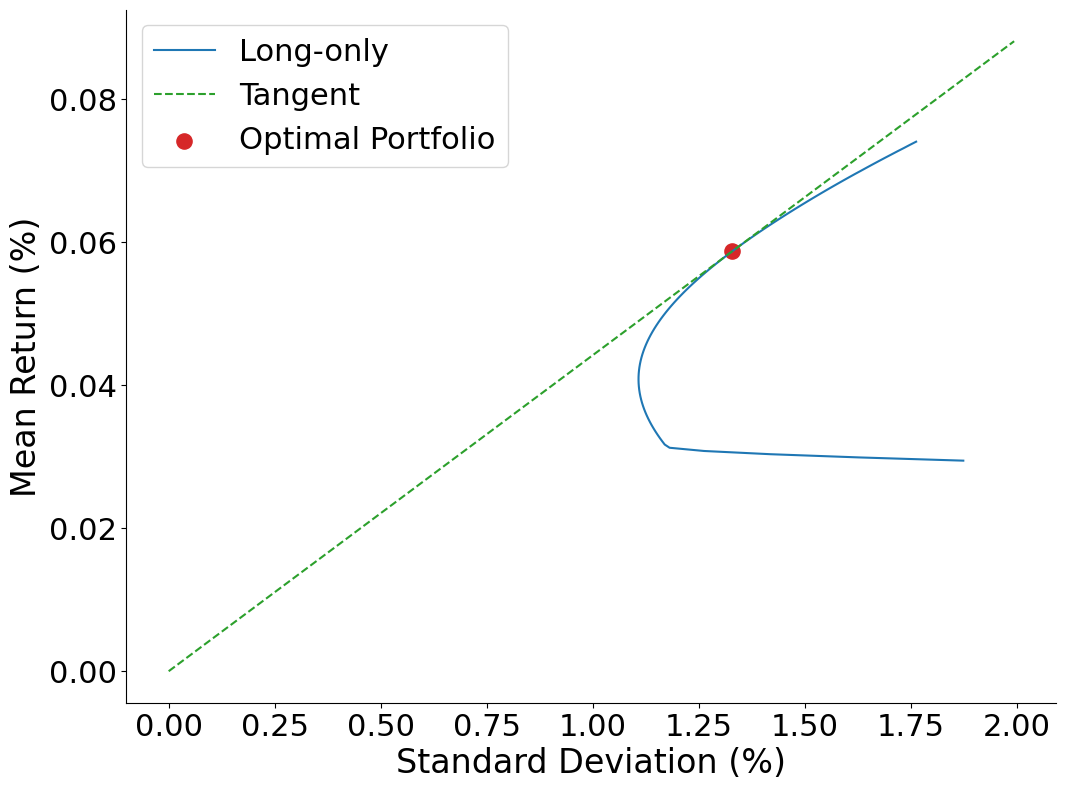

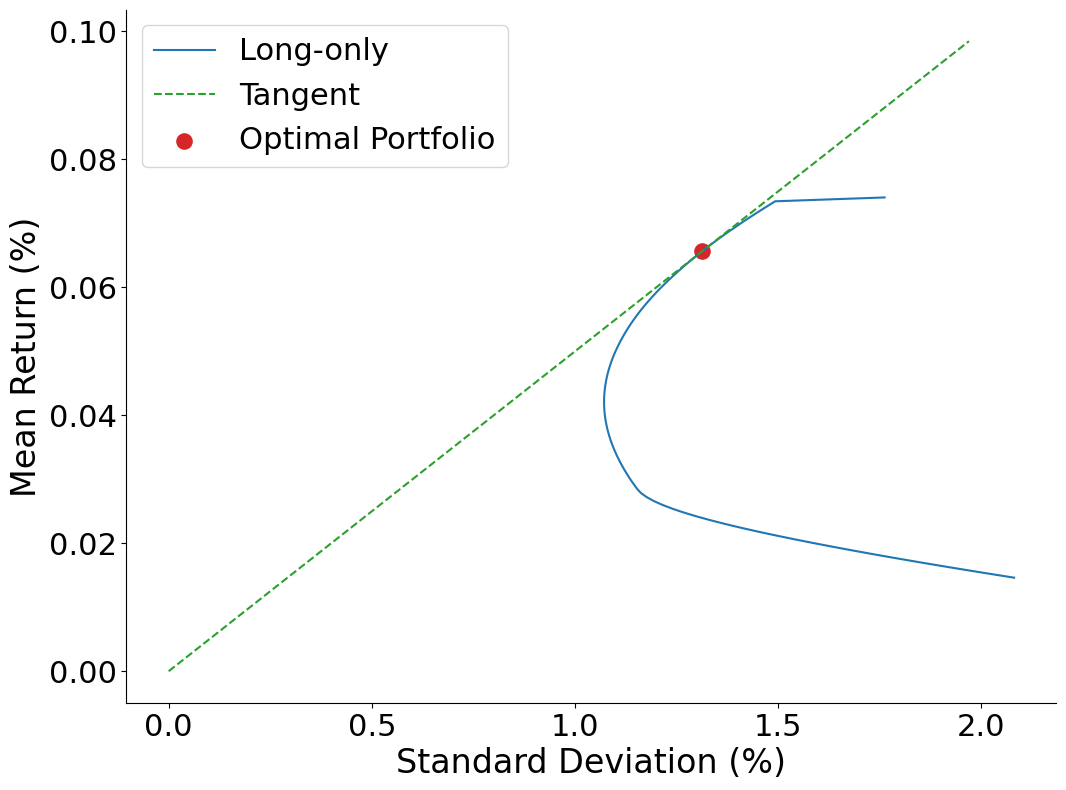

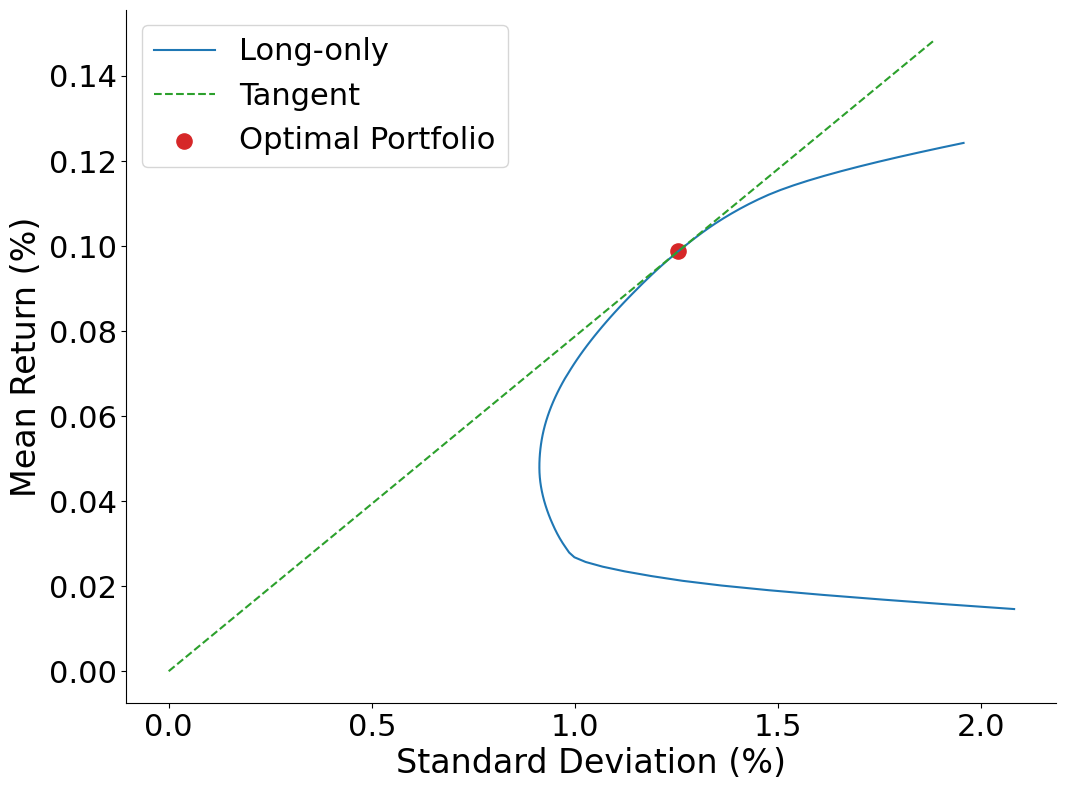

In [9]:
# Optimal portfolio plots
portfolio_allocations = {}
portfolio_returns = {}
portfolio_sharpe = {}

for n in [3, 5, 10]:
    allocations, sd_optimal, mu_optimal, sd_x, mu_x = MV_weights(np.array(returns.iloc[:, :n]))

    # Minimum variance frontiers
    plt.figure(figsize = (12, 9))
    plt.plot(100 * sd_x, 100 * mu_x, label = "Long-only")
    plt.plot([0, 100 * sd_optimal, 1.5 * 100 * sd_optimal], [0, 100 * mu_optimal, 1.5 * 100 * mu_optimal],
         label = "Tangent", color = "tab:green", ls = "--")
    plt.scatter(100 * sd_optimal, 100 * mu_optimal, label = "Optimal Portfolio", color = "tab:red", s = 120)
    plt.xlabel('Standard Deviation (%)', fontsize = 24)
    plt.ylabel('Mean Return (%)', fontsize = 24)
    plt.xticks(fontsize = 22)
    plt.yticks(fontsize = 22)
    plt.legend(loc = "upper left", fontsize = 22)
    plt.show()

    port_returns = np.multiply(returns.iloc[:, :n].values, allocations).sum(axis = 1)
    port_sharpe = sharpe_ratio(port_returns)
    # Storing results
    portfolio_allocations[f"MV{n}"] = allocations
    portfolio_returns[f"MV{n}"] = port_returns
    portfolio_sharpe[f"MV{n}"] = port_sharpe

In [10]:
for n in [3, 5, 10]:
  print(f"###### {n} stocks ######")
  for i in range(n):
    print(f"{tickers[i]}: {round(portfolio_allocations[f'MV{n}'][i] * 100, 2)}%")
  print(f"Sharpe ratio: {round(portfolio_sharpe[f'MV{n}'] * 100, 3)}%")

###### 3 stocks ######
WOW.AX: 30.89%
QBE.AX: 5.32%
COH.AX: 63.79%
Sharpe ratio: 4.419%
###### 5 stocks ######
WOW.AX: 18.89%
QBE.AX: 0.43%
COH.AX: 50.52%
ORG.AX: 0.02%
TWE.AX: 30.15%
Sharpe ratio: 4.998%
###### 10 stocks ######
WOW.AX: 0.01%
QBE.AX: 0.0%
COH.AX: 7.99%
ORG.AX: 0.0%
TWE.AX: 9.08%
BHP.AX: 2.73%
CBA.AX: 4.11%
TLS.AX: 0.0%
GMG.AX: 42.46%
ALL.AX: 33.63%
Sharpe ratio: 7.874%


NN LSTM Helper Functions

In [11]:
# Adapted from https://github.com/shilewenuw/deep-learning-portfolio-optimization/blob/main/Model.py
def sharpe_loss_wrapper(returns):
    def sharpe_loss(_, y_pred):

      # y_pred will correspond to asset weights
      
      cast_returns = tf.cast(tf.constant(returns), float)
      portfolio_returns = tf.reduce_sum(tf.multiply(cast_returns, y_pred), axis = 1)

      sharpe = K.mean(portfolio_returns) / K.std(portfolio_returns)
      
      # loss is negative of Sharpe ratio
      return -sharpe
    return sharpe_loss

In [12]:
def NN_weights(prices, returns):
  # Adapted from https://github.com/shilewenuw/deep-learning-portfolio-optimization/blob/main/Model.py
  '''
  Used to plot loss function

  inputs: 
    prices - DataFrame of historical daily closing prices
    returns - Dataframe of returns, same observations as prices
  returns: 
    history object of NN
  '''
  
  assert prices.shape == returns.shape

  # Preparing inputs
  prices_returns = np.concatenate([prices, returns], axis = 1)
  n_stocks = returns.shape[1]

  tf.random.set_seed(1234)

  # LSTM 
  LSTM_model = Sequential([
      LSTM(64, input_shape = prices_returns.shape),
      Flatten(),
      Dense(n_stocks, activation = "softmax")
  ])

  LSTM_model.compile(loss = sharpe_loss_wrapper(returns), optimizer = "adam")

  fit_predict_data = prices_returns[np.newaxis,:]
  hist = LSTM_model.fit(fit_predict_data, np.zeros((1, n_stocks)), epochs=50, shuffle=False, verbose = 0)

  allocations = LSTM_model.predict(fit_predict_data)[0]

  return allocations, hist


NN Results

In [13]:
for n in [3, 5, 10]:
    allocations, _ = NN_weights(np.array(prices.iloc[:, :n]), np.array(returns.iloc[:, :n]))
    port_returns = np.multiply(returns.iloc[:, :n].values, allocations).sum(axis = 1)
    port_sharpe = sharpe_ratio(port_returns)
    # Storing results
    portfolio_allocations[f"NN{n}"] = allocations
    portfolio_returns[f"NN{n}"] = port_returns
    portfolio_sharpe[f"NN{n}"] = port_sharpe

1/1 [==============================] - 0s 287ms/step


In [14]:
for n in [3, 5, 10]:
  print(f"###### {n} stocks ######")
  for i in range(n):
    print(f"{tickers[i]}: {round(portfolio_allocations[f'NN{n}'][i] * 100, 2)}%")
  print(f"Sharpe ratio: {round(portfolio_sharpe[f'NN{n}'] * 100, 3)}%")

###### 3 stocks ######
WOW.AX: 31.76%
QBE.AX: 4.91%
COH.AX: 63.32%
Sharpe ratio: 4.419%
###### 5 stocks ######
WOW.AX: 18.55%
QBE.AX: 6.03%
COH.AX: 46.0%
ORG.AX: 2.75%
TWE.AX: 26.66%
Sharpe ratio: 4.92%
###### 10 stocks ######
WOW.AX: 4.0%
QBE.AX: 2.41%
COH.AX: 11.85%
ORG.AX: 2.11%
TWE.AX: 10.26%
BHP.AX: 3.48%
CBA.AX: 7.95%
TLS.AX: 2.49%
GMG.AX: 28.95%
ALL.AX: 26.51%
Sharpe ratio: 7.544%


Grouped Bar Charts

<Figure size 1200x900 with 0 Axes>

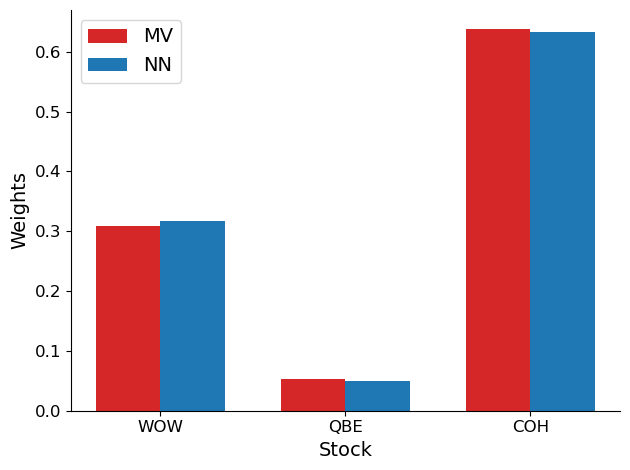

<Figure size 1200x900 with 0 Axes>

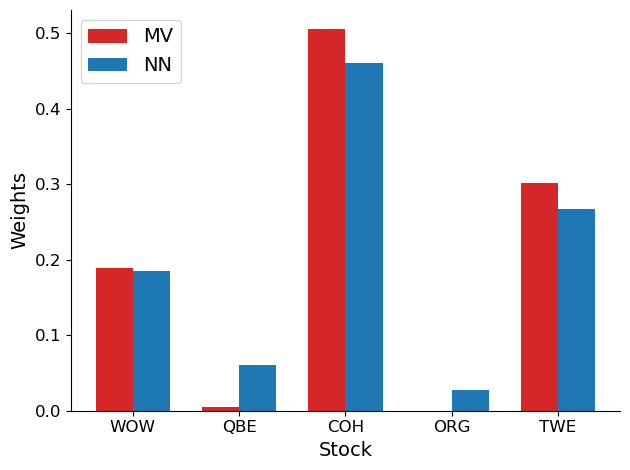

<Figure size 1200x900 with 0 Axes>

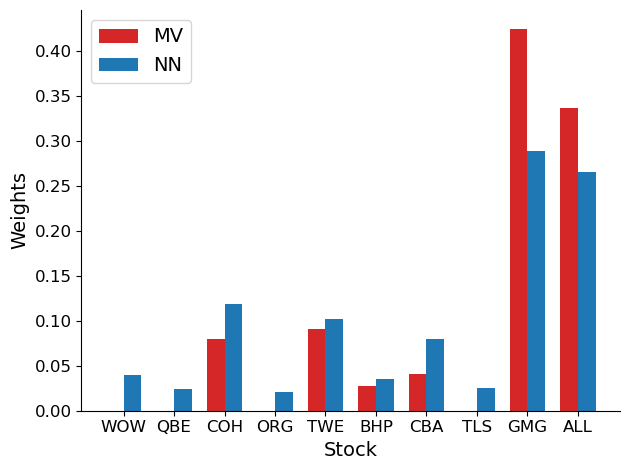

In [15]:
for n in [3, 5, 10]:
    plt.figure(figsize = (12, 9))
    labels = [stock.removesuffix(".AX") for stock in tickers[:n]]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, portfolio_allocations[f"MV{n}"], width, label='MV', color = "tab:red")
    rects2 = ax.bar(x + width/2, portfolio_allocations[f"NN{n}"], width, label='NN', color = "tab:blue")

    ax.set_ylabel('Weights', fontsize = 14)
    ax.set_xlabel('Stock', fontsize = 14)
    ax.set_xticks(x, labels, fontsize = 12)
    plt.yticks(fontsize = 12)
    ax.legend(loc = "upper left", fontsize = 14)

    # ax.bar_label(rects1, padding=3)
    # ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    plt.show()

LSTM Loss Curve

1/1 [==============================] - 0s 263ms/step


(array([-8. , -7.5, -7. , -6.5, -6. , -5.5, -5. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

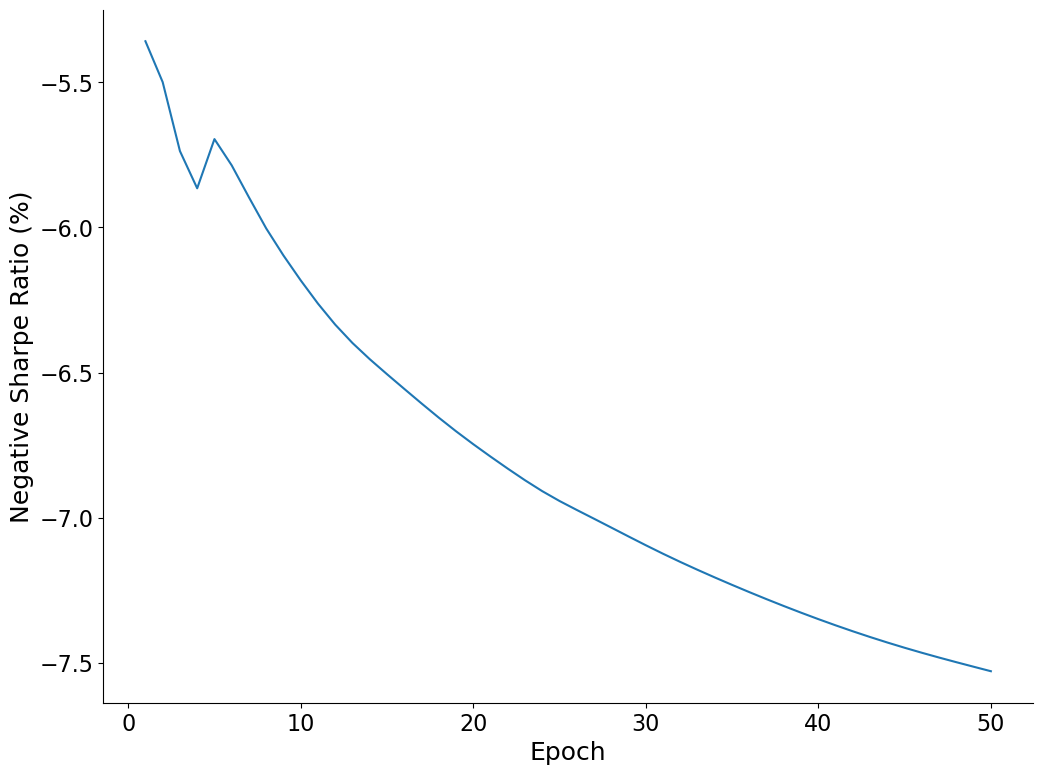

In [16]:
_, hist_10 = NN_weights(prices, returns)

plt.figure(figsize = (12, 9))
plt.plot(range(1, 51), np.array(hist_10.history["loss"]) * 100)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Negative Sharpe Ratio (%)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)


Equally Weighted Portfolio

In [17]:
def EW_weights(returns):
  n_stocks = returns.shape[1]
  allocations = 1/n_stocks * np.ones(n_stocks)

  return allocations

In [18]:
for n in [3, 5, 10]:
    allocations = EW_weights(np.array(returns.iloc[:, :n]))
    port_returns = np.multiply(returns.iloc[:, :n].values, allocations).sum(axis = 1)
    port_sharpe = sharpe_ratio(port_returns)
    # Storing results
    portfolio_allocations[f"EW{n}"] = allocations
    portfolio_returns[f"EW{n}"] = port_returns
    portfolio_sharpe[f"EW{n}"] = port_sharpe

for n in [3, 5, 10]:
  print(f"###### {n} stocks ######")
  for i in range(n):
    print(f"{tickers[i]}: {round(portfolio_allocations[f'EW{n}'][i] * 100, 2)}%")
  print(f"Sharpe ratio: {round(portfolio_sharpe[f'EW{n}'] * 100, 3)}%")

###### 3 stocks ######
WOW.AX: 33.33%
QBE.AX: 33.33%
COH.AX: 33.33%
Sharpe ratio: 3.848%
###### 5 stocks ######
WOW.AX: 20.0%
QBE.AX: 20.0%
COH.AX: 20.0%
ORG.AX: 20.0%
TWE.AX: 20.0%
Sharpe ratio: 3.81%
###### 10 stocks ######
WOW.AX: 10.0%
QBE.AX: 10.0%
COH.AX: 10.0%
ORG.AX: 10.0%
TWE.AX: 10.0%
BHP.AX: 10.0%
CBA.AX: 10.0%
TLS.AX: 10.0%
GMG.AX: 10.0%
ALL.AX: 10.0%
Sharpe ratio: 5.631%


Random Weights

In [19]:
def RW(returns, n_sim = 1000):
  '''
  inputs: returns - numpy array of returns, with timestep rows and stocks columns
  '''
  n_stocks = returns.shape[1]

  np.random.seed(1)
  RW_sharpe = []

  for _ in range(n_sim):
    # Simulating weights
    allocations = np.random.uniform(0.0, 1.0, n_stocks)
    allocations = allocations / sum(allocations)
    
    portfolio_returns = np.multiply(returns, allocations).sum(axis = 1)
    RW_sharpe.append(sharpe_ratio(portfolio_returns))

  return np.mean(RW_sharpe)


In [20]:
for n in [3, 5, 10]:
    portfolio_sharpe[f"RW{n}"] = RW(np.array(returns.iloc[:, :n]))

for n in [3, 5, 10]:
  print(f"###### {n} stocks ######")
  print(f"Sharpe ratio: {round(portfolio_sharpe[f'RW{n}'] * 100, 3)}%")

###### 3 stocks ######
Sharpe ratio: 3.615%
###### 5 stocks ######
Sharpe ratio: 3.603%
###### 10 stocks ######
Sharpe ratio: 5.489%
